In [ ]:
!pip install PyDrive

In [ ]:
!pip install shap

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import seaborn as sns
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
import math
import shap
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import geopy.distance

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#2. Get the file
downloaded = drive.CreateFile({'id':"17TlCXfs4WKyo8nshLrTGoVTLOvP6CIyr"})   # replace the id with id of file you want to access
downloaded.GetContentFile('fraudTrain.csv')

In [ ]:
#3. Read file as panda dataframe
import pandas as pd
data = pd.read_csv('fraudTrain.csv')

In [ ]:
data.shape

(1296675, 23)

In [ ]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data.dtypes['trans_date_trans_time']

data['transaction_hour'] = data['trans_date_trans_time'].dt.hour

t = data.groupby('transaction_hour').count()
t = t['trans_num']
t = pd.DataFrame(t)
t = t.rename(columns={'trans_num':'Actual_transaction'})

fraud_t = data.loc[data['is_fraud']==1]
tf = fraud_t.groupby('transaction_hour').count()
tf = tf['trans_num']

time = pd.concat([t, tf], axis=1)
time[['Actual_transaction','trans_num']]

time = time.rename(columns={'trans_num':'Fradulent_transaction'})

time['Fradulent_transaction'] = time['Fradulent_transaction'].fillna(0)

time['fraud_rate%_by_hour'] = (time['Fradulent_transaction'] / time['Actual_transaction']) * 100

time = time.sort_values(['fraud_rate%_by_hour'], ascending=False)
fr_time = pd.DataFrame(time['fraud_rate%_by_hour'])

act_time = data['transaction_hour']
act_time = pd.DataFrame(act_time)

new_time = pd.merge(act_time, fr_time, how='left', on='transaction_hour')
new_time

In [ ]:
data['transaction_hour'] = new_time['fraud_rate%_by_hour']

In [ ]:
t_categ_anal = data.groupby('category')[['trans_num']].count().reset_index()
t_categ_anal.rename({'trans_num':'total_count_of_trasactions'}, axis=1)

f_categ_anal = data[data['is_fraud']==1].groupby('category')[['trans_num']].count().reset_index()
f_categ_anal.rename({'trans_num':'count_of_fraud_trasactions'}, axis=1)

categ_anal = pd.merge(t_categ_anal, f_categ_anal, how='left', on='category')
categ_anal['fraud_perc'] = (categ_anal['trans_num_y'] / categ_anal['trans_num_x']) * 100
categ_anal = categ_anal.sort_values(['fraud_perc'], ascending=False)

t_job_anal = data.groupby('job')[['trans_num']].count().reset_index()
t_job_anal = t_job_anal.sort_values(['trans_num'], ascending=False)

f_job_anal = data[data['is_fraud']==1].groupby('job')[['trans_num']].count().reset_index()
f_job_anal = f_job_anal.sort_values(['trans_num'], ascending=False)

job_anal = pd.merge(t_job_anal, f_job_anal, how='inner', on='job')
job_anal['fraud_perc'] = (job_anal['trans_num_y'] / job_anal['trans_num_x']) * 100
job_anal = job_anal.sort_values(['fraud_perc'], ascending=False)
high_fraud = job_anal[job_anal['fraud_perc'] > 90]
#high_fraud = pd.DataFrame(high_fraud['job'])
high_fraud_job = high_fraud['job'].tolist()

new_job = []

for job in data['job']:
  for fraud_job in high_fraud_job:
    if fraud_job == job:
      new_job.append('high risk')
      break
  else:
    new_job.append('low risk')

data['job'] = new_job

In [ ]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(data[['job']]).toarray())
enc_df
data = data.join(enc_df)

In [ ]:
data.rename({0:'low risk job', 1:'high risk job'}, axis=1, inplace=True)

In [ ]:
z = data.groupby('zip').count()
z = z['city']
z = pd.DataFrame(z)
z = z.rename(columns={'city':'Actual_transaction'})

fraud = data.loc[data['is_fraud']==1]
zf = fraud.groupby('zip').count()
zf = zf['city']

zip = pd.concat([z, zf], axis=1)
zip[['Actual_transaction','city']]

zip = zip.rename(columns={'city':'Fradulent_transaction'})

zip['Fradulent_transaction'] = zip['Fradulent_transaction'].fillna(0)

zip['fraud_rate%'] = (zip['Fradulent_transaction'] / zip['Actual_transaction']) * 100

zip = zip.sort_values(['fraud_rate%'], ascending=False)
fr_zip = pd.DataFrame(zip['fraud_rate%'])

# Replacing Zip codes with fraud rates
act_zip = data['zip']
act_zip = pd.DataFrame(act_zip)

new_zip = pd.merge(act_zip, fr_zip, how='left', on='zip')

data['zip'] = new_zip['fraud_rate%']
data['zip']

In [ ]:
data['amt'] = np.log(data['amt'])
data['amt'].skew()

In [ ]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(data[['gender']]).toarray())
enc_df
data = data.join(enc_df)

In [ ]:
data.rename({0:'female', 1:'male'}, axis=1, inplace=True)

In [ ]:
data['category'].replace({'misc_net':1, 'grocery_pos':2, 'entertainment':3, 'gas_transport':4, 'misc_pos':5, 'grocery_net':6, 'shopping_net':7, 'shopping_pos':8, 'food_dining':9, 'personal_care':10, 'health_fitness':11, 'travel':12, 'kids_pets':13, 'home':14})

In [ ]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(data[['category']]).toarray())
enc_df
data = data.join(enc_df)

In [ ]:
data.rename({0:'misc_net', 1:'grocery_pos', 2:'entertainment', 3:'gas_transport', 4:'misc_pos', 5:'grocery_net', 6:'shopping_net', 7:'shopping_pos', 8:'food_dining', 9:'personal_care', 10:'health_fitness', 11:'travel', 12:'kids_pets', 13:'home'}, axis=1, inplace=True)

In [ ]:
data['day_of_week'] = data['trans_date_trans_time'].dt.day_name()
data['day_of_week']

In [ ]:
label_encoder = preprocessing.LabelEncoder()
data['day_of_week'] = label_encoder.fit_transform(data['day_of_week'])
data['day_of_week'].unique()

array([5, 6, 4, 0, 2, 3, 1])

In [ ]:
data.columns

In [ ]:
Y = data['is_fraud']

In [ ]:
data.drop(columns=['Unnamed: 0','is_fraud','trans_date_trans_time','dob','trans_num','unix_time','merch_lat','merch_long','cc_num', 'street','city','state','lat','long','merchant','category', 'first','last','gender', 'job', 'female', 'low risk job'], axis=1, inplace=True)

In [ ]:
X = data.copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(907672, 21) (389003, 21) (907672,) (389003,)


In [ ]:
y_test.isna().sum()

0

In [ ]:
xgb_instance = xgb.XGBClassifier() 
model_for_feature_selection = xgb_instance.fit(X_train, y_train)

In [ ]:
# check the importances - you can also use SHAP values
feature_importance = {'Feature':X_train.columns,'Importance':model_for_feature_selection.feature_importances_}
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values("Importance", inplace=True,ascending=False)
feature_importance

In [ ]:
params = {
            'objective':'binary:logistic',
            'max_depth': 6,
            'learning_rate': 1.0,
            'n_estimators':100
        }

xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_train, y_train)

XGBClassifier(learning_rate=1.0, max_depth=6)

In [ ]:
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)[:,1]

In [ ]:
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.9980


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
table = pd.DataFrame(columns = ["Num Trees", "Learning_rate", "max_depth", "AUC_Train", "AUC_Test"])

row = 0

for num_trees in [50, 100]:
  for lr in [0.1, 0.2, 0.3]:
    for num_layers in [3,5,7]:
    
        xgb_clf = XGBClassifier(n_estimators=num_trees, learning_rate=lr, max_depth=num_layers)
        model = xgb_clf.fit(X_train, y_train)

        table.loc[row,"Num Trees"] = num_trees
        table.loc[row,"learning_rate"] = lr
        table.loc[row, 'max_depth'] = num_layers
        table.loc[row,"AUC_Train"] = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
        table.loc[row,"AUC_Test"] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

        row = row + 1

table 

In [ ]:
X_train_ss = X_train[:60000]

In [ ]:
shap.initjs()

In [ ]:
shap_values = shap.TreeExplainer(xgb_clf, feature_perturbation='interventional').shap_values(X_train_ss)
# shap.summary_plot(shap_values, X_train, plot_type='bar')

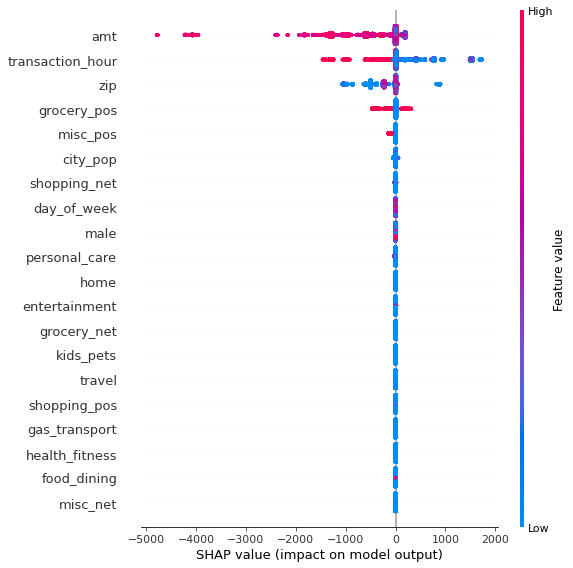

In [ ]:
shap.summary_plot(shap_values, X_train_ss)

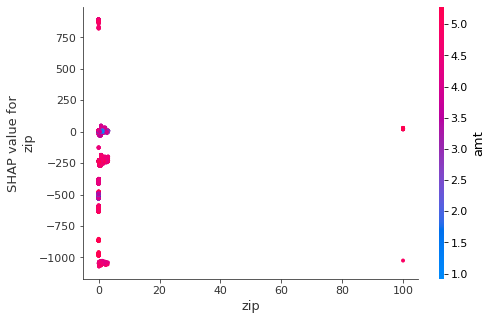

In [ ]:
shap.dependence_plot('zip', shap_values, X_train_ss)

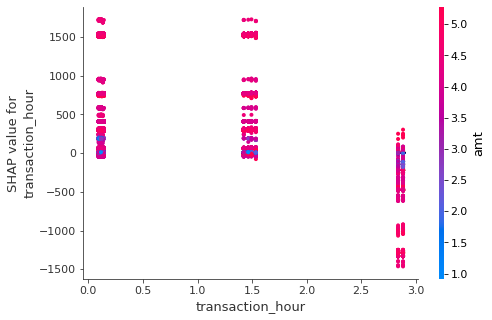

In [ ]:
shap.dependence_plot('transaction_hour', shap_values, X_train_ss)

# Model Analysis

In [ ]:
y_df = pd.DataFrame(y_test)
y_df['pred_fraud'] = y_pred
y_df['pred_prob'] = y_pred_prob
y_df.sort_values(by='pred_prob')
y_df['rank'] = y_df['pred_prob'].rank()

In [ ]:
s1, s2 = np.split(y_df, [int(.10 *len(y_df))])
s2, s3 = np.split(s2, [int(.10 *len(s2))])
s3, s4 = np.split(s3, [int(.10 *len(s3))])
s4, s5 = np.split(s4, [int(.10 *len(s4))])
s5, s6 = np.split(s5, [int(.10 *len(s5))])
s6, s7 = np.split(s6, [int(.10 *len(s6))])
s7, s8 = np.split(s7, [int(.10 *len(s7))])
s8, s9 = np.split(s8, [int(.10 *len(s8))])
s9, s10 = np.split(s9, [int(.10 *len(s9))])

In [ ]:
s1['compare'] = np.where(s1['is_fraud'] == s1['pred_prob'], True, False)
s2['compare'] = np.where(s2['is_fraud'] == s2['pred_prob'], True, False)
s3['compare'] = np.where(s3['is_fraud'] == s3['pred_prob'], True, False)
s4['compare'] = np.where(s4['is_fraud'] == s4['pred_prob'], True, False)
s5['compare'] = np.where(s5['is_fraud'] == s5['pred_prob'], True, False)
s6['compare'] = np.where(s6['is_fraud'] == s6['pred_prob'], True, False)
s7['compare'] = np.where(s7['is_fraud'] == s7['pred_prob'], True, False)
s8['compare'] = np.where(s8['is_fraud'] == s8['pred_prob'], True, False)
s9['compare'] = np.where(s9['is_fraud'] == s9['pred_prob'], True, False)
s10['compare'] = np.where(s10['is_fraud'] == s10['pred_prob'], True, False)

s1_avg = (s1[s1['compare']==True]['is_fraud'].sum())/s1.shape[0]
s2_avg = (s1[s1['compare']==True]['is_fraud'].sum())/s2.shape[0]
s3_avg = (s1[s1['compare']==True]['is_fraud'].sum())/s3.shape[0]
s4_avg = (s1[s1['compare']==True]['is_fraud'].sum())/s4.shape[0]
s5_avg = (s1[s1['compare']==True]['is_fraud'].sum())/s5.shape[0]
s6_avg = (s1[s1['compare']==True]['is_fraud'].sum())/s6.shape[0]
s7_avg = (s1[s1['compare']==True]['is_fraud'].sum())/s7.shape[0]
s8_avg = (s1[s1['compare']==True]['is_fraud'].sum())/s8.shape[0]
s9_avg = (s1[s1['compare']==True]['is_fraud'].sum())/s9.shape[0]
s10_avg = (s1[s1['compare']==True]['is_fraud'].sum())/s10.shape[0]

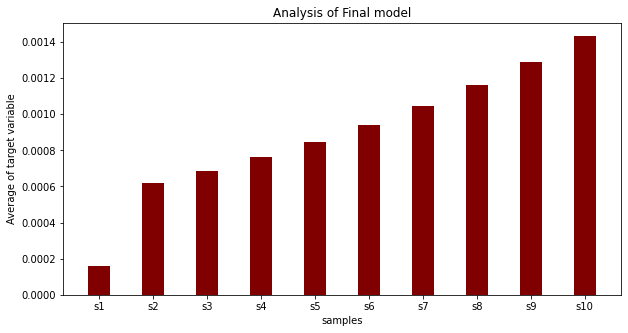

In [ ]:
import matplotlib.pyplot as plt

avg = {'s1':s1_avg, 's2':s2_avg, 's3':s3_avg, 's4':s4_avg, 's5':s5_avg, 's6':s6_avg, 's7':s7_avg, 's8':s8_avg, 's9':s9_avg, 's10':s10_avg}
labels = list(avg.keys())
values = list(avg.values())
values.sort()
fig = plt.figure(figsize = (10, 5))

plt.bar(labels, values, color ='maroon', width = 0.4)
plt.xlabel("samples")
plt.ylabel("Average of target variable")
plt.title("Analysis of Final model")
plt.show()

In [ ]:
from sklearn .model_selection import KFold
model = XGBClassifier()
kfold_validation = KFold(10)

import numpy as np
from sklearn.model_selection import cross_val_score
results = cross_val_score(model, X_test, y_test, cv=kfold_validation)
print(results)
print(np.mean(results))

[0.99784067 0.99735225 0.99778926 0.99791774 0.99796915 0.99758355
 0.99796915 0.9977635  0.99771208 0.9977635 ]
0.9977660848787003
